## Summary

After analysis (all code is below), it was found that a user's total number of logins and the number of days between a user's account creation and most recent login were by far the most important factors in predicting user adoption. The organization id also showed some importance. The following courses of action may be helpful:

* Engage in marketing efforts to encourage users to continue using the platform, and to use it frequently. This could invovle email reminders for users who have not recently logged in or discounts or support for certain users. Specifically, users who have recently signed up for the platform could be targeted to increase the likelihood that they grow accustomed to using the service. 
* We can also analyze which organizations have users that tend to be adopters and which organizations tend to have users that are not adopters. This will allow us to focus on managing relationships with organizations that tend to be high adopters. We can also discover why individuals at some organizations tend to be low adopters - we may be able to offer additional training/support, discounts, or new product features to these individuals.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, ensemble, metrics
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load the Data

In [2]:
#load the user data

path = 'takehome_users.csv'

df_users = pd.read_csv(path)

In [3]:
#load the usage data

path = 'takehome_user_engagement.csv'

df_usage = pd.read_csv(path)

## 3. Data Wrangling

### Users Table

In [4]:
#users table
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
#rename object_id to user_id
df_users = df_users.rename(columns={'object_id':'user_id'})

In [7]:
df_users.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


### Usage Table

In [8]:
#usage table
df_usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [9]:
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [10]:
df_usage['time_stamp'] = pd.to_datetime(df_usage.time_stamp)

In [11]:
df_usage.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [12]:
#determine which users are adopted


#normalize the time stamps (so that we can group by date)
df_usage['time_stamp'] = df_usage.time_stamp.dt.normalize()

#get the unique login dates for each user
user_logins = df_usage.groupby(['user_id','time_stamp']).agg({'visited':'count'})
user_logins = user_logins.reset_index()
user_logins = user_logins.sort_values(by=['user_id','time_stamp'])

#dict to track which users are adopted
user_adopted = dict()

#check adoption status for each user
for user_id in user_logins.user_id.unique():
    
    #filter logins for current user
    mask = user_logins.user_id == user_id
    
    #get the min. days between 3 consecutive logins
    min_diff = user_logins[mask].time_stamp.diff(2).dt.days.min()
    
    #check if user is adopted
    if min_diff <= 7:
        user_adopted[user_id] = True

#default the adopted column to False
df_usage['adopted'] = False

#set adopted column to True for adopted users
df_usage.loc[df_usage.user_id.isin(list(user_adopted.keys())), 'adopted'] = True

In [13]:
#track the total number of logins for each user

login_counts = df_usage.groupby('user_id')\
    .agg({'visited':'count'})\
    .rename(columns={'visited':'login_count'})

df_usage = pd.merge(df_usage,login_counts, left_on='user_id', right_index=True)

In [14]:
#drop unneeded columns in the usage table
df_usage = df_usage.drop(columns=['time_stamp','visited'])

In [15]:
#drop duplicate rows in the usage table
df_usage =  df_usage.drop_duplicates().set_index('user_id')

### Join The User and Usage Data

In [16]:
#join the adopted column and user table

df_users = df_users.set_index('user_id')
df_users = pd.concat([df_users, df_usage],axis=1)

#Set adopted to False for users who have never logged in
df_users.loc[df_users.adopted.isna(),'adopted'] = False

In [17]:
#check the adoption rate
adoption_rate = np.sum(df_users.adopted) / len(df_users.adopted)
print('Adoption rate: {}%'.format(adoption_rate * 100))

Adoption rate: 13.8%


Note that this data has a slight imbalance (a little greater than 6:1). However, this is not a severe imbalance so we can try a model without any oversampling or undersampling techniques.

### Missing Values

In [18]:
#last_session_creation_time contains missing values.
#time between a user's most recent session and creation_time will be calculated where possible
#last_session_creation_time and creation_time will then be dropped

df_users['last_session_creation_time'] = pd.to_datetime(df_users.last_session_creation_time, unit='s')
df_users['creation_time'] = pd.to_datetime(df_users.creation_time)
df_users['usage_window_in_days'] = (df_users.last_session_creation_time - df_users.creation_time).dt.days
df_users.loc[df_users.usage_window_in_days.isna(),'usage_window_in_days'] = 0

df_users = df_users.drop(columns=['last_session_creation_time','creation_time'])

In [19]:
#invited_by_user_id contains missing values. Whether or not a user was invited, and the number of invitations
# issued by a user will be tracked. invited_by_user_id will then be dropped.

#track the number of invites issued by each user
number_of_invites = pd.DataFrame(df_users.invited_by_user_id.value_counts())
number_of_invites.index = number_of_invites.index.astype(int)
number_of_invites = number_of_invites.rename(columns={'invited_by_user_id':'number_of_invites'})
df_users = pd.concat([df_users,number_of_invites], axis=1)
df_users.loc[df_users.number_of_invites.isna(),'number_of_invites'] = 0

#track whether a user was invited
df_users['was_invited'] = False
df_users.loc[df_users['invited_by_user_id'].notna(), 'was_invited'] = True

#drop invited_by_user_id
df_users = df_users.drop(columns=['invited_by_user_id'])

In [20]:
#login_count has null values because some users never logged in - replace nulls with 0
df_users.loc[df_users.login_count.isna(), 'login_count'] = 0

In [21]:
#get domain names from the email addresses
df_users['email_domain'] = df_users.email.str.split('@').str[1]
df_users['email_domain'] = df_users.email_domain.str.split('.').str[0]
df_users.email_domain.value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
qgjbc            2
oqpze            2
luque            2
Name: email_domain, dtype: int64

In [22]:
#6 domains account for almost all email addresses - label all other domains "OTHER"

common_domains = df_users.email_domain.value_counts().iloc[0:6].index.to_list()
df_users.loc[ ~ df_users.email_domain.isin(common_domains), 'email_domain'] = 'OTHER'


#drop the email column
df_users = df_users.drop(columns=['email'])

In [23]:
#drop the name column
df_users = df_users.drop(columns=['name'])

## 4. Preprocessing

In [24]:
random_state = 42

In [25]:
#convert boolean columns (adopted, was_invited) to integer columns
df_users['adopted'] = df_users.adopted.astype(int)
df_users['was_invited'] = df_users.was_invited.astype(int)

In [26]:
#encode the org_id column using label encoding
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(df_users.org_id)
df_users['org_id'] = labels

In [27]:
#encode the creation_source and email_domain columns using one hot encoding  
encoder = preprocessing.OneHotEncoder(sparse=False)

lst_features = ['creation_source','email_domain']

columns_to_encode = df_users[lst_features]

encoded_cols = pd.DataFrame(encoder.fit_transform(columns_to_encode),
                           columns=encoder.get_feature_names(lst_features),
                           index=columns_to_encode.index)

df_users = pd.concat([df_users,encoded_cols],axis=1)

df_users = df_users.drop(columns=['creation_source','email_domain'])

In [28]:
#train/test split
X = df_users.drop(columns=['adopted'])
y = df_users[['adopted']]

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

## 5. Modeling

In [29]:
#method to train, predict, and score the model
def train_predict_score(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train,y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = metrics.accuracy_score(y_train,y_pred_train)
    train_auc = metrics.roc_auc_score(y_train,y_pred_train)
    test_accuracy = metrics.accuracy_score(y_test,y_pred_test)
    test_auc = metrics.roc_auc_score(y_test,y_pred_test)
    
    return {'train_accuracy':train_accuracy,
           'train_auc':train_auc,
           'test_accuracy':test_accuracy,
           'test_auc':test_auc}

In [30]:
#dataframe for model scores
df_scores = pd.DataFrame(columns=['model','train_accuracy','train_auc','test_accuracy','test_auc'])

**Random Forest Model**

In [31]:
#Random Forest model
rf_model = ensemble.RandomForestClassifier(random_state=random_state)

results = train_predict_score(rf_model, X_train, y_train, X_test, y_test)
results['model'] = 'Random Forest'
df_scores = df_scores.append(results, ignore_index=True)

<ipython-input-29-af658cf5bf42>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


In [32]:
df_scores

,model,train_accuracy,train_auc,test_accuracy,test_auc
0,Random Forest,1.0,1.0,0.983889,0.965307


## 6. Feature Importance

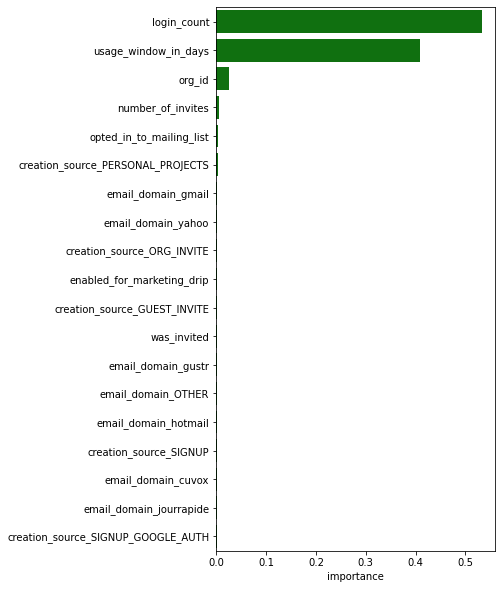

In [33]:
df_feature_importances = \
    pd.DataFrame(rf_model.feature_importances_, index=X_train.columns, columns=['importance']) \
        .sort_values(by='importance', ascending=False)

plt.figure(figsize=(5,10))
sns.barplot(data=df_feature_importances, y=df_feature_importances.index, x='importance', color='green', orient='h');